### импорт библиотек

In [1]:
!pip install torchsummary

In [2]:
import torch
import pandas as pd
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from torchvision.models import Inception_V3_Weights
from torchvision.models import DenseNet161_Weights
from torchvision.models import VGG16_Weights


### загрузка данных EMNIST

In [3]:
BATCH_SIZE = 256

In [4]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split = 'letters', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split = 'letters', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:18<00:00, 29787720.22it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [5]:
print(f'Data size:\n\t train {len(train_dataset)},\n\t test {len(test_dataset)}')
print(f'Data shape:\n\t features {train_dataset[0][0].shape},\n\t target {type(test_dataset[0][1])}')

Data size:
	 train 124800,
	 test 20800
Data shape:
	 features torch.Size([3, 299, 299]),
	 target <class 'int'>


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [33]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n, test_loss_sum = 0, 0, 0
    net.eval()
    loss = nn.CrossEntropyLoss(reduction='sum')

    for X, y in data_iter:
        y = y-1
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        test_loss_sum += l.item()
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    acc = acc_sum.item() / n
    test_loss = test_loss_sum / n
    return acc, test_loss

In [38]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    history_l_train = []
    history_acc_train = []
    history_l_test = []
    history_acc_test = []
    history_l_e_train = []

    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()
        
        for i, (X, y) in enumerate(train_iter):
            y = y - 1
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat[0], y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat[0].argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {(train_acc_sum / n)*100:.3f}%. Train Loss: {train_l_sum / n:.3f}")
            history_l_train.append(train_l_sum / n) # сохранение тренировочного лосса в список для визуализации
            # history_acc_train.append(train_acc_sum / n) # сохранение тренировочного accuracy в список

        test_acc, test_loss = evaluate_accuracy(test_iter, net.to(device))
        test_acc = round(test_acc*100, 3)

        history_l_e_train.append(train_l_sum / n) # сохранение тренировочного лосса в список для визуализации
        history_acc_test.append(test_acc) # сохранение тестового accuracy
        history_l_test.append(test_loss) # сохранение тестового loss


        print('-' * 20)
        print(f'epoch {epoch + 1}, loss_train {train_l_sum / n:.4f}, train acc {(train_acc_sum / n)*100:.3f}%'
              f', loss_test { test_loss:.4f}, test acc {test_acc}%, time {time.time() - start:.1f} sec')
        print('-' * 60)

    return history_l_e_train, history_l_test, history_acc_test

In [9]:
model_inception = tv.models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
# model_inception

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 73.8MB/s] 


In [ ]:
summary(model_inception.to(device), input_size=(3, 299, 299))

In [11]:
# Убираем требование градиента:
for param in model_inception.parameters():
    param.requires_grad = False

In [12]:
model_inception.fc = nn.Linear(in_features=2048, out_features=26)

In [13]:
print("Params to learn:")
params_to_update = []
for name, param in model_inception.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [14]:
# model, params_to_update = use_model(model_inception)
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [15]:
epoch = 10

In [39]:
loss_train_ep, loss_test, acc_inception = train(model_inception, train_iter, test_iter, trainer, epoch)

Step 0. time since epoch: 1.308. Train acc: 69.531%. Train Loss: 0.923
Step 100. time since epoch: 138.111. Train acc: 68.154%. Train Loss: 1.003
Step 200. time since epoch: 274.002. Train acc: 68.301%. Train Loss: 0.995
Step 300. time since epoch: 409.906. Train acc: 68.258%. Train Loss: 0.996
Step 400. time since epoch: 545.833. Train acc: 68.232%. Train Loss: 0.999
--------------------
epoch 1, loss_train 0.9992, train acc 68.231%, loss_test 0.7195, test acc 77.894%, time 769.4 sec
------------------------------------------------------------
Step 0. time since epoch: 1.569. Train acc: 69.922%. Train Loss: 0.967
Step 100. time since epoch: 136.055. Train acc: 68.197%. Train Loss: 0.999
Step 200. time since epoch: 270.508. Train acc: 68.322%. Train Loss: 0.999
Step 300. time since epoch: 404.763. Train acc: 68.330%. Train Loss: 1.000
Step 400. time since epoch: 539.158. Train acc: 68.362%. Train Loss: 0.997
--------------------
epoch 2, loss_train 0.9987, train acc 68.304%, loss_test 

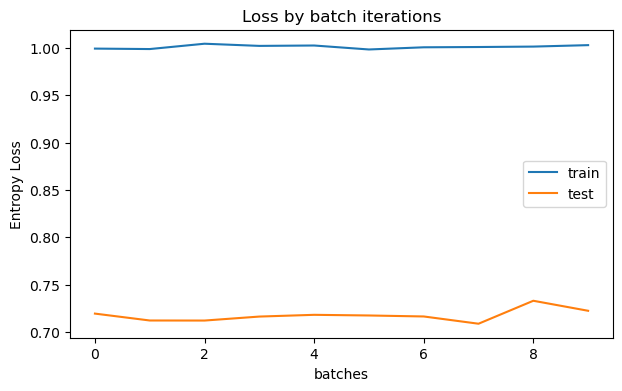

In [40]:
# график для отображения динамики loss
plt.figure(figsize=(7, 4))

plt.plot(loss_train_ep, label = 'train')
plt.plot(loss_test, label = 'test')

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')
plt.legend()
plt.show()